# all_sky_NSB-map

Fourth step for all-sky calibration. 
This version reads with the RGB images (as FITS files) and uses
- the astrometry obtained by all_sky_astrometry_V4-RGB.ipynb	
- the photometry zero points for each channel found by all_sky_photometry.ipynb

based in Jia Yin et al. MNRAS 537,617-627 (2025)
"Calibration and applications of the all-sky camera at the Ali Observatory in Tibet"
National Astronomical Observatories, Chinese Academy of Sciences

Testing in 
Pic du Midi Observatory (France), Canon EOS6D + Sigma 8mm f/3.5,  Rémi Boucher 
ifile = 'IMG_9467.CR2' 
tz = ZoneInfo('Europe/Paris')
location = ['Pic du Midi Observatory', 0.14, 42.94, 2877] #[longitude.deg, latitude.deg, height.m]

INPUT : - RGB corrected images from RAW picture created by 'all_sky_vignetting.ipynb' 
        - WCS coordinates transformation as 'asdf' file (RA-DEC WCS)
        - zero points obtained from all_sky_photometry.ipynb
OUTPUT: Night Sky brightness map in each channel

version 2025/06/01  This is a working notebook to test different methods


#### Some necessary packages
probably more than needed. 
> TODO: review not used packages

In [1]:
# -------------------------
# Standard Python libraries
# -------------------------
import os
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from fractions import Fraction

# ---------------------
# Third party libraries
# ---------------------
import matplotlib.pyplot as plt

import pytz
import exifread
import numpy as np 

import asdf

import astropy.units as u
from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.modeling.projections import Sky2Pix_ZEA

from gwcs.wcstools import wcs_from_points


#from photutils import aperture
from photutils.aperture import CircularAperture
#from photutils.aperture import CircularAnnulus
from photutils.aperture import aperture_photometry

## Reading the RGB images
<pre> 
The images R1 G2 G3 B4 are the individual channels for the original RGB RAW picture.
They were corrected from vignetting and the astrometry is already done.</pre>
>TODO: add BIAS value to the corrected images

In [2]:
ipath   = os.path.join(os.getcwd(), "remi")
#ipath   = os.path.join(os.getcwd(), "./")
ifile = os.path.join(ipath, 'IMG_9467.CR2') 

### Timestamping issues
The EXIF data contained in the image ia a *naive* datetime, that is, without any timezone information. So we need to know if this timezone is UTC or local time and what is the proper timezone. The pytz library helps to localize and convert the time stamp to UTC.
In this case, although the location is Pic du Midi in France, the camera was set to Canada/Eastern local time ! Code below converts the local datetime into an UTC Python datetime, then into an Astropy's Time object.

In [3]:
with open(ifile, 'rb') as f:
    exif_tags = exifread.process_file(f)
texpo = float(Fraction(str(exif_tags.get('EXIF ExposureTime'))))
dt = str(exif_tags.get('Image DateTime'))
dt = datetime.strptime(dt, "%Y:%m:%d %H:%M:%S")
timezone = pytz.timezone("Canada/Eastern")
dt = timezone.localize(dt).astimezone(pytz.utc)
obstime=Time(dt)
obstime

<Time object: scale='utc' format='datetime' value=2023-10-11 22:13:56>

### Location
The sample image - made by Rémi Boucher - was located in Pic du Midi Observatory (France)

In [4]:
location = ['Pic du Midi Observatory', 0.14, 42.94, 2877] #[longitude.deg, latitude.deg, height.m]
elocation = EarthLocation(lon=location[1]*u.deg, lat=location[2]*u.deg, height=location[3]*u.m)
elocation

<EarthLocation (4678588.82787972, 11431.97186664, 4324584.42528495) m>

In [5]:
azalt_frame = AltAz(obstime=obstime, location=elocation)
azalt_frame

<AltAz Frame (obstime=2023-10-11 22:13:56, location=(4678588.827879718, 11431.97186663711, 4324584.425284955) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron)>

#### Reading the FITS files with the R G B channles

In [6]:
filename = ifile.replace('.CR2','_R1_corr.fits')
header = fits.getheader(filename)
R1  = fits.getdata(filename)

filename = ifile.replace('.CR2','_G2_corr.fits')
header = fits.getheader(filename)
G2  = fits.getdata(filename)

filename = ifile.replace('.CR2','_G3_corr.fits')
header = fits.getheader(filename)
G3  = fits.getdata(filename)

filename = ifile.replace('.CR2','_B4_corr.fits')
header = fits.getheader(filename)
B4  = fits.getdata(filename)
print(header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 3132                                                  NAXIS2  =                 2090                                                  EXTEND  =                    T                                                  FILENAME= 'IMG_9467_B4_corr.fits'                                               HISTORY --------------------                                                    HISTORY 2025-05-10 10:39:16                                                     HISTORY Corrected from vignetting using flat-sigma-8-f35_EOS6DMII.fits          HISTORY B4 channel                                                              END                                                                                                                     

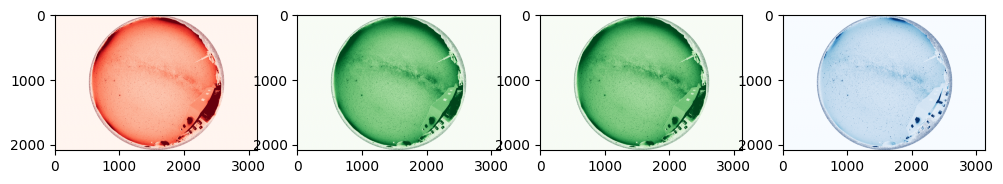

In [7]:
vmin , vmax = 0 , 900
fig,ax = plt.subplots(1,4,figsize=(12,6))
ax[0].imshow(R1,cmap='Reds',vmin=vmin,vmax=vmax)
ax[1].imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax)
ax[2].imshow(G3,cmap='Greens',vmin=vmin,vmax=vmax)
ax[3].imshow(B4,cmap='Blues',vmin=vmin,vmax=vmax)

#### Read the result of coordinate transformation
<pre>
The asdf file contents the WCS astrometry transformation.
The WCS transform from pixel X,Y to RA & DEC
</pre>

In [8]:
# RA & DEC  GWCS 
ofile = ifile.replace('.CR2','_wcs.asdf')  # the wcs obtained with the astrometry procedure
asdf_file = asdf.open(ofile)
print('Using WCS astrometry after calibration ', ofile)
# WCS transform in RA & DEC
gwcs_radec = asdf_file.tree['wcs']

## filetab contains the star catalog saved after calibration
filetab = ifile.replace('.CR2','_coords.csv')
print('Reading catalog RA,DEC and X,Y table   ', filetab, ' to an astropy Table')
tab = Table.read(filetab)

print(azalt_frame)
# AZ & ALT  GWCS 
tab_radec = SkyCoord(tab['index_ra'], tab['index_dec'], unit=(u.deg, u.deg),frame='icrs')
xy = ((tab['field_x'],tab['field_y']))
rd0 = SkyCoord(0., 90.,unit='deg',frame='icrs')
tab_altaz = tab_radec.transform_to(azalt_frame)
gwcs_azalt = wcs_from_points(xy, tab_altaz, proj_point=rd0,\
                             projection=Sky2Pix_ZEA(),poly_degree=6, polynomial_type='polynomial')

Using WCS astrometry after calibration  /home/rafa/Escritorio/all_sky_nsb/remi/IMG_9467_wcs.asdf
Reading catalog RA,DEC and X,Y table    /home/rafa/Escritorio/all_sky_nsb/remi/IMG_9467_coords.csv  to an astropy Table
<AltAz Frame (obstime=2023-10-11 22:13:56, location=(4678588.827879718, 11431.97186663711, 4324584.425284955) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron)>


In [9]:
G2.shape
xc = int(G2.shape[1]/2)
yc = int(G2.shape[0]/2)

## Grid of az&alt regions

1573.1821478504542 487.5447703085566


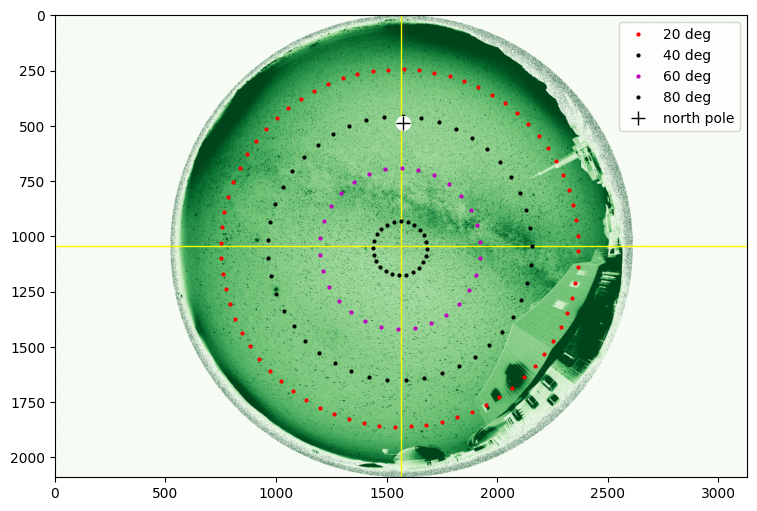

In [10]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax)
plt.axvline(xc,lw=1,color='yellow')
plt.axhline(yc,lw=1,color='yellow')
caz  = np.arange(0,360,5)   # [0,90,180,270]
calt = [20] * len(caz)
xd,yd = gwcs_azalt.backward_transform(caz, calt)
plt.plot(xd,yd,'ro',ms = 2,label='20 deg')
caz  = np.arange(0,360,8)  
calt = [40] * len(caz)
xd,yd = gwcs_azalt.backward_transform(caz, calt)
plt.plot(xd,yd,'ko',ms = 2,label='40 deg')
caz  = np.arange(0,360,12)  
calt = [60] * len(caz)
xd,yd = gwcs_azalt.backward_transform(caz, calt)
plt.plot(xd,yd,'mo',ms = 2,label='60 deg')
caz  = np.arange(0,360,15)  
calt = [80] * len(caz)
xd,yd = gwcs_azalt.backward_transform(caz, calt)
plt.plot(xd,yd,'ko',ms = 2,label='80 deg')

xo,yo = gwcs_radec.backward_transform(0, 90)
print(xo,yo)
plt.plot(xo,yo,'wo',ms=10)
plt.plot(xo,yo,'k+',ms=10,label='north pole')
plt.legend()

plt.savefig('fig_az-alt_grid.png')

### Sampling grid test

In [11]:
alt = [0.,5.0, 11.0, 14.0, 15.0, 14.0, 11.0, 5.0, 9.0, 18.0, 24.0, 28.0, 29.0, 28.0, 24.0, 18.0, 9.0, 9.0, 20.0, 29.0, 36.0, 41.0, 42.0, 41.0, 36.0, 29.0, 20.0, 9.0, 5.0, 18.0, 29.0, 39.0, 47.0, 53.0, 55.0, 53.0, 47.0, 39.0, 29.0, 18.0, 5.0, 11.0, 24.0, 36.0, 47.0, 57.0, 64.0, 67.0, 64.0, 57.0, 47.0, 36.0, 24.0, 11.0, 14.0, 28.0, 41.0, 53.0, 64.0, 74.0, 78.0, 74.0, 64.0, 53.0, 41.0, 28.0, 14.0, 0.0, 15.0, 29.0, 42.0, 55.0, 67.0, 78.0, 90.0, 78.0, 67.0, 55.0, 42.0, 29.0, 15.0, 0.0, 14.0, 28.0, 41.0, 53.0, 64.0, 74.0, 78.0, 74.0, 64.0, 53.0, 41.0, 28.0, 14.0, 11.0, 24.0, 36.0, 47.0, 57.0, 64.0, 67.0, 64.0, 57.0, 47.0, 36.0, 24.0, 11.0, 5.0, 18.0, 29.0, 39.0, 47.0, 53.0, 55.0, 53.0, 47.0, 39.0, 29.0, 18.0, 5.0, 9.0, 20.0, 29.0, 36.0, 41.0, 42.0, 41.0, 36.0, 29.0, 20.0, 9.0, 9.0, 18.0, 24.0, 28.0, 29.0, 28.0, 24.0, 18.0, 9.0, 5.0, 11.0, 14.0, 15.0, 14.0, 11.0, 5.0, 0.0]
azi = [180.,207.0, 198.0, 189.0, 180.0, 171.0, 162.0, 153.0, 141.0, 149.0, 158.0, 169.0, 180.0, 191.0, 202.0, 211.0, 219.0, 231.0, 225.0, 217.0, 207.0, 194.0, 180.0, 166.0, 153.0, 143.0, 135.0, 129.0, 117.0, 121.0, 127.0, 135.0, 146.0, 162.0, 180.0, 198.0, 214.0, 225.0, 233.0, 239.0, 243.0, 252.0, 248.0, 243.0, 236.0, 225.0, 207.0, 180.0, 153.0, 135.0, 124.0, 117.0, 112.0, 108.0, 99.0, 101.0, 104.0, 108.0, 117.0, 135.0, 180.0, 225.0, 243.0, 252.0, 256.0, 259.0, 261.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 0.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 81.0, 79.0, 76.0, 72.0, 63.0, 45.0, 0.0, 315.0, 297.0, 288.0, 284.0, 281.0, 279.0, 288.0, 292.0, 297.0, 304.0, 315.0, 333.0, 0.0, 27.0, 45.0, 56.0, 63.0, 68.0, 72.0, 63.0, 59.0, 53.0, 45.0, 34.0, 18.0, 0.0, 342.0, 326.0, 315.0, 307.0, 301.0, 297.0, 309.0, 315.0, 323.0, 333.0, 346.0, 0.0, 14.0, 27.0, 37.0, 45.0, 51.0, 39.0, 31.0, 22.0, 11.0, 0.0, 349.0, 338.0, 329.0, 321.0, 333.0, 342.0, 351.0, 0.0, 9.0, 18.0, 27.0, 0.0]
print(len(azi),len(alt))

149 149


NameError: name 'xxn' is not defined

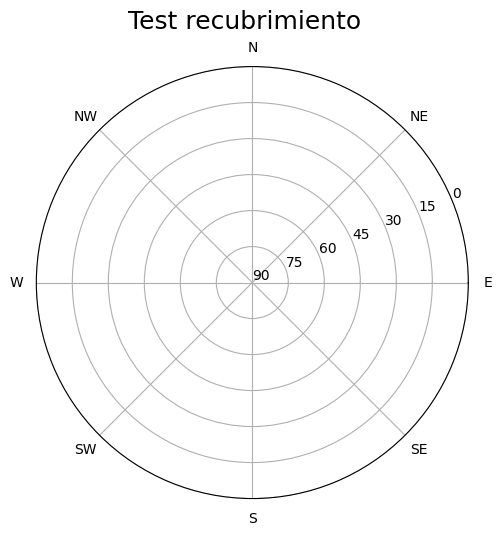

In [12]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.03, 0.15, 0.95, 0.72], polar=True) #, axisbg='#d5de9c')
plt.grid(True)

ring_angles = [ (x+0.000001) * (np.pi/180.) for x in range(0,100,15)]
ring_labels = [ str(x) for x in range(0,100,15)]
ring_labels.reverse()
lines,labels = plt.rgrids(ring_angles,ring_labels)
angles,labels = plt.thetagrids( range(360,0,-45), ( 'E', 'SE', 'S', 'SW', 'W','NW', 'N', 'NE') )

label = u"Test recubrimiento"
ax.text(1.6,1.85, label, fontsize=18, horizontalalignment='center')

plt.plot(xxn,yyn,'ko',ms=3)


In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax)
plt.axvline(xc,lw=1,color='yellow')
plt.axhline(yc,lw=1,color='yellow')
for i in range(len(azi)):
    xd,yd = gwcs_azalt.backward_transform(azi[i], alt[i])
    plt.plot(xd,yd,'ro',ms = 3)


#### escale factor area in pixels to area in arcsec2 

In [ ]:
# Obtained during astrometry
fvalue = 716.5193798435873
# In general there is a variable escale along the zenit angle
#ydr = np.rad2deg(1./(fvalue/2*np.cos(zen/2.)))*3600.
#ydl = np.rad2deg(1./(fvalue *np.sin(zen/2.)))*3600.
#domega = np.sin(zen)*ydr*ydl*np.pi/180. ## = 38683 *pi/180
# For ZEA (equal area) there is a fixed escale 
ydr = np.rad2deg(1./(fvalue/2*np.cos(0.01/2.)))*3600.
ydl = np.rad2deg(1./(fvalue *np.sin(0.01/2.)))*3600.
print(ydr,ydl)
domega = np.sin(0.1)*ydr*ydl*np.pi/180. 
print('escale factor area in pixels to area in arcsec2 ',domega)

In [ ]:
zpB = 10.93
zpG = 11.11
zpR = 10.0
#expo = 120.2

#### Mean value at grid points

In [ ]:
positions = []
radius = 80
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax)
plt.axvline(xc,lw=1,color='yellow')
plt.axhline(yc,lw=1,color='yellow')
for i in range(len(azi)):
    xd,yd = gwcs_azalt.backward_transform(azi[i], alt[i])
    positions.append((xd,yd))
apertures_star = CircularAperture(positions, r=radius)
apertures_star.plot(color='red', lw=1);
plt.show()
tbl_phot = aperture_photometry(data = G2.data, apertures=apertures_star)
print(tbl_phot[0:5])
print(apertures_star.area)
tbl_phot['xcenter'].info.format = '.2f'
tbl_phot['ycenter'].info.format = '.2f'
tbl_phot['aperture_sum'].info.format = '.2f'
tbl_phot["flux"] = tbl_phot['aperture_sum']/(apertures_star.area*texpo)
tbl_phot["sb"] = np.round(zpG - 2.5*np.log10(tbl_phot['flux']/domega),2)
tbl_phot["azi"] = azi
tbl_phot["zen"] = 90 - np.array(alt)
tbl_phot[0:5]



In [ ]:
tbl_phot[88]

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax*2)
plt.axvline(xc,lw=1,color='yellow')
plt.axhline(yc,lw=1,color='yellow')
apertures_star.plot(color='red', lw=1);
for x, y, sb in zip(tbl_phot["xcenter"], tbl_phot["ycenter"], tbl_phot["sb"]):
    plt.text(x,y,sb,ha='center',fontsize=8)
    


In [ ]:
plt.hist(tbl_phot['sb'])

In [ ]:
cms = plt.matplotlib.cm
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax)
#plt.axvline(xc,lw=1,color='yellow')
#plt.axhline(yc,lw=1,color='yellow')
apertures_star.plot(color='red', lw=1);
for x, y, sb in zip(tbl_phot["xcenter"], tbl_phot["ycenter"], tbl_phot["sb"]):
     plt.text(x,y,sb,ha='center',fontsize=8)
     color = cms.gray(sb/22)
     circle = plt.Circle((x, y), radius, color=color)
     ax.add_artist(circle)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,9))
ax[0].imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax*2)
plt.axvline(xc,lw=1,color='yellow')
plt.axhline(yc,lw=1,color='yellow')
apertures_star.plot(color='red', lw=1);
for x, y, sb in zip(tbl_phot["xcenter"], tbl_phot["ycenter"], tbl_phot["sb"]):
    ax[0].text(x,y,sb,ha='center',fontsize=6)
ax[0].set_xlim(500,2650)
ax[1].imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax*2)
for x, y, sb in zip(tbl_phot["xcenter"], tbl_phot["ycenter"], tbl_phot["sb"]):
     plt.text(x,y,sb,ha='center',fontsize=6)
     color = cms.gray(sb/22)
     circle = plt.Circle((x, y), radius, color=color)
     ax[1].add_artist(circle) 
ax[1].set_xlim(500,2650)

#### Contour plots

In [ ]:
# --------------------
# System wide imports
# -------------------

from enum import Enum, IntEnum, StrEnum
from typing import Tuple

# =====================
# Third party libraries
# =====================

import numpy as np
from numpy.typing import ArrayLike

import astropy
from astropy.coordinates import Angle
from astropy import units as u

from scipy.interpolate import griddata

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Type annotations
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.colors import LinearSegmentedColormap

# Handy enumerations

class Magnitude(float, Enum):
    SUPER_BRIGHT = 8.0
    BRIGHT = 10
    MODERATE = 17
    MEDIUM_DARK = 18.6
    SUPER_DARK = 22.0
    BLACK = 24.0


class Azimuth(IntEnum):
    N = 0
    NE = 45
    E = 90
    SE = 135
    S = 180
    SW = 225
    W = 270
    NW = 315


class ObserverType(StrEnum):
    PERSON = "Individual"
    ORG = "Organization"
    
def observer_name(observer: dict) -> str:
    """Handy formatting tool to get a good observer name"""
    name = observer["name"]
    if ObserverType(observer["type"]) == ObserverType.PERSON:
        if observer["affiliation"] is not None:
            long_affil = observer["affiliation"]["name"]
            short_affil = (
                observer["affiliation"]["acronym"]
                if observer["affiliation"]["acronym"] is not None
                else ""
            )
            affiliation = short_affil or long_affil
            result = f"{name} ({affiliation})"
        else:
            result = name
    else:
        result = f"{name} ({observer['acronym']})" if observer["acronym"] else name
    return result


def interpolate(
    azimuths: ArrayLike,  # in degrees
    zenitals: ArrayLike,  # in degrees
    zvalues: ArrayLike,  # can be magnitudes or temperatures
    grid_step: float = 1.0,  # in degrees
) -> Tuple[ArrayLike, ArrayLike, ArrayLike]:
    """Interpolate magnitudes across the azimuth, zenital axis"""

    # Generate a finer grid in zenital and azimuth axis (in degrees)
    zen_axis = np.arange(0, np.max(zenitals) + grid_step, grid_step)
    azi_axis = np.arange(0, 360 + grid_step, grid_step)
    # prepare the bidimensional grid for interpolation
    zen_grid, azi_grid = np.meshgrid(zen_axis, azi_axis)
    # Extend the Azimuths array to -360 to +360 circles
    extended_azi = np.ravel([azimuths - 360, azimuths, azimuths + 360])
    # and duplicate data along the extended azimuth axes
    extended_zen = np.ravel([zenitals, zenitals, zenitals])
    extended_zval = np.ravel([zvalues, zvalues, zvalues])
    # Interpolated magnitudes for the grid points
    interpolated_zval = griddata(
        (extended_zen, extended_azi), extended_zval, (zen_grid, azi_grid), method="cubic"
    )
    # INTERPOLATED zvalues as array instead of meshgrid
    interpolated_zval = np.array(interpolated_zval).reshape(len(azi_axis), len(zen_axis))
    return np.radians(azi_grid), zen_grid, interpolated_zval


def colormap() -> LinearSegmentedColormap:
    """make a 256 point combined colormap from reversed viridis and YlOrRd"""
    NC1 = 192
    colors2 = plt.cm.viridis_r(np.linspace(0, 1, NC1))
    colors1 = plt.cm.YlOrRd_r(np.linspace(0, 1, 256 - NC1))
    colors = np.vstack((colors1, colors2))
    return mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)


def plot_add_metadata(
    fig: Figure, observation: dict, observer: dict, location: dict, optics: dict
) -> None:
    latitude = Angle(location["latitude"] * u.deg).to_string(
        precision=0, alwayssign=True,  format="latex_inline"
    )
    longitude = Angle(location["longitude"] * u.deg).to_string(
        precision=0, alwayssign=True,  format="latex_inline"
    )
    fig.text(0.90, 0.28, f"{observation['timestamp_1']}", size=14, ha="right")
    fig.text(0.90, 0.26, f"Optics: {optics['name']}", size=14, ha="right")
    # fig.text(0.90, 0.17, self.file_txt_reduced, fontsize=12, horizontalalignment="right")
    fig.text(0.12, 0.28, rf"LONG {longitude}", size=14, ha="left")
    fig.text(0.12, 0.26, rf"LAT  {latitude}", size=14, ha="left")
    name = observer_name(observer)[:100]
    fig.text(0.5, 0.96, name, ha="center", size=12)


def plot_interpolated(
    tag: str,
    azimuths: ArrayLike,
    zenitals: ArrayLike,
    magnitudes: ArrayLike,
    min_mag: float,
    max_mag: float,
    nticks: int,  # Number of xticks labels to avoid crowding
    dark_mag: float = Magnitude.BRIGHT,  # Threshold magnitude for brightness cmap steps
    thres_mag: float = Magnitude.MEDIUM_DARK,  # Threshold magnitude for brightness cmap steps
) -> Figure:
    fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(9, 12))
    ax.set_theta_zero_location(Azimuth.N.name)  # Set the north to the north
    ax.set_theta_direction(-1)
    ax.set_xticks(np.deg2rad([e.value for e in Azimuth]))
    ax.set_xticklabels([e.name for e in Azimuth], fontdict={"fontsize": 14})
    ax.tick_params(pad=1.2)
    cmap = colormap()
    # Plot the TAS data as tiny red dots for reference
    ax.scatter(np.radians(azimuths), zenitals, c="red", zorder=2, s=8)
    azi_grid, zen_grid, interp_mag = interpolate(azimuths, zenitals, zvalues=magnitudes)
    m_step_1 = 0.2  # 0.2 initial step in contour levels
    m_step_2 = 0.4
    if np.max(magnitudes) > dark_mag:  # 21 dark place
        lev_c_b = np.arange(thres_mag, max_mag + m_step_1 + 0.1, m_step_1)
        # more width between contour line for lower magnitudes
        lev_c_a = np.arange(min_mag, thres_mag, m_step_2)
        lev_f = np.arange(min_mag, max_mag + m_step_1 + 0.1, m_step_2)
    else:
        lev_f = np.arange(min_mag, max_mag, m_step_1)  # visible contour lines
    cb_ticks = np.round(np.linspace(min_mag, max_mag, num=nticks, endpoint=True), 1)
    cax = ax.contourf(
        azi_grid,
        zen_grid,
        interp_mag,
        levels=lev_f,
        cmap=cmap,
        vmin=min_mag,
        vmax=max_mag,
    )
    cax_lines = ax.contour(cax, colors="w", levels=lev_c_b, linewidths=2)
    ax.clabel(
        cax_lines,
        colors="w",
        inline=True,
        fmt="%1.1f",
        rightside_up=True,
        fontsize="medium",
    )
    cax_lines = ax.contour(cax, colors="k", levels=lev_c_a, linewidths=1)
    ax.clabel(
        cax_lines,
        colors="k",
        inline=True,
        fmt="%1.1f",
        rightside_up=True,
        fontsize="medium",
    )
    # extra contour lines over 22 mag/arcsec2
    high_levels = np.arange(Magnitude.SUPER_DARK, Magnitude.BLACK, m_step_2)
    cax_lines = ax.contour(cax, colors="k", levels=high_levels, linewidths=1)
    ax.clabel(
        cax_lines,
        colors="k",
        inline=True,
        fmt="%1.1f",
        rightside_up=True,
        fontsize="medium",
    )
    # extra contour lines below 17 mag/arcsec2
    low_levels = np.arange(Magnitude.SUPER_BRIGHT, Magnitude.MODERATE, 1)
    cax_lines = ax.contour(cax, colors="k", levels=low_levels, linewidths=0.5)
    ax.clabel(
        cax_lines,
        colors="k",
        inline=True,
        fmt="%1.1f",
        rightside_up=True,
        fontsize="small",
    )
    # Draw the color bar
    cb = fig.colorbar(cax, orientation="horizontal", fraction=0.35, ticks=cb_ticks, pad=0.08)
    cb.set_label("Sky Brightness [mag/arcsec$^2$]", fontsize=14)
    cb.ax.tick_params(labelsize=12)
    # Cut the axes to fit data
    ax.set_ylim(0, max(zenitals))
    ax.set_title(tag, size=15)  # 25
    return fig


def plot(
    tag: str,
    azimuths: ArrayLike,
    zenitals: ArrayLike,
    magnitudes: ArrayLike,
    min_mag: float = Magnitude.MODERATE,
    max_mag: float = Magnitude.SUPER_DARK,
    nticks: int = 6, #12,  # Number of xticks labels to avoid crowding
    thr_mag: float = 17, # 10,  # Threshold magnitude for brightness cmap steps
    observation: dict = None,  # Additional observation metadata
    observer: dict = None,  # Additional observer metadata
    location: dict = None,  # Additional location metadata
    optics: dict = None,  # Additional photometer metadata
) -> Figure:
    """Produce a color map of sky night brightness"""
    fig = plot_interpolated(
            tag=tag,
            azimuths=azimuths,
            zenitals=zenitals,
            magnitudes=magnitudes,
            min_mag=min_mag,
            max_mag=max_mag,
            nticks=nticks,
        )
    if observation is not None:
        assert observer is not None
        assert location is not None
        assert optics is not None
        plot_add_metadata(fig, observation, observer, location, optics)
    return fig

In [ ]:
observer = {
    "name": "Rémi Boucher", "type": ObserverType.PERSON,
    "affiliation": None,
}
optics = {"name": "Canon EOS6D + Sigma 8mm f/3.5"}
location = {"place": "Pic du Midi Observatory", "longitude": 0.14, "latitude": 42.94, "height": 2877}
observation = {"timestamp_1": f'{dt.strftime("%Y-%m-%d %H:%M:%S")} UTC' }

In [ ]:
fig = plot(
    tag=location["place"],
    azimuths=tbl_phot["azi"],
    zenitals=tbl_phot["zen"],
    magnitudes=(tbl_phot["sb"]),
    min_mag=Magnitude.MODERATE,
    max_mag=Magnitude.SUPER_DARK,
    observation=observation,
    location=location,
    observer=observer,
    optics=optics,
)

# HASTA AQUI

### Photometry zero points
<pre>
    Previously obtained during the photometry step.
    Inserted here but ToDo --> create a file with the photometry results
</pre>

In [ ]:
# stars 20 deg up   zenit angele z<70
#   zero point      extinction coeff   color term
# B 10.93 +/- 0.06    0.48 +/- 0.04    -0.12 +/- 0.04
# G 11.11 +/- 0.06    0.41 +/- 0.04    -0.1 +/- 0.07
# R 10.0 +/- 0.06    0.37 +/- 0.04    0.0 +/- 0.06
zpB = 10.93
zpG = 11.11
zpR = 10.0
expo = 120.2

In [ ]:
vmin , vmax = 0 , 900
fig,ax = plt.subplots(1,1,figsize=(6,3))
ax.imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax)
plt.axvline(xc,lw=2,color='yellow')
plt.axhline(yc,lw=2,color='yellow')
sizex , sizey = 300 , 200
x1 = xc - int(sizex / 2)
x2 = xc + int(sizex / 2)
y1 = yc - int(sizey / 2)
y2 = yc + int(sizey / 2)
ax.add_patch(plt.Rectangle((x1, y1), sizex, sizey, ls="-", ec="yellow", lw=2,fc="none"))
media = np.mean(G2[y1:y2,x1:x2])
print(y1,y2,x1,x2)
area = (x2 -x1) * (y2-y1)
print(media, area , media/area, media/area / expo)
m = zpG - 2.5 * np.log10(media/expo)
print(m)

# escala aproximada:
escale =  180 * 3600 / G2.shape[0] 
print(G2.shape[0],escale, 'arcsec/pixel')
factor = escale * escale
print(factor,'arsec2/pixel',2.5*np.log10(factor),'NSB G zenit',m+2.5*np.log10(factor))